<a href="https://colab.research.google.com/github/romerofernandes/power_consumption_predict/blob/main/power_consumption_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações

###Bibliotecas

In [1]:
#Analise de dados
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

In [4]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [5]:
#! pip install scikit-optimize

In [6]:
#Otimização de hiperparametros 
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
#from skopt import BayesSearchCV
#from skopt.space import Integer

In [7]:
#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [8]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

###Dados

####Dados de consumo

In [9]:
#Dados sobre o consumo de energia elétrica

df_consumption = pd.read_csv('/content/power_usage_2016_to_2020.csv', 
                             parse_dates= ['StartDate'])

In [10]:
df_consumption.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [11]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [12]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_consumption.duplicated().sum()}")

Valores duplicados: 0


In [13]:
df_consumption.notes.unique()

array(['weekday', 'weekend', 'vacation', 'COVID_lockdown'], dtype=object)

In [14]:
df_consumption.drop(columns=['notes','day_of_week'], inplace=True)

In [15]:
df_consumption.sort_values(by='StartDate').head()

,StartDate,Value (kWh)
0,2016-01-06 00:00:00,1.057
1,2016-01-06 01:00:00,1.171
2,2016-01-06 02:00:00,0.560
3,2016-01-06 03:00:00,0.828
4,2016-01-06 04:00:00,0.932


In [16]:
#Renomeando a coluna de consumo
df_consumption.rename(columns={'Value (kWh)': 'consumption', 'StartDate':'Date'}, inplace=True)

In [17]:
df_consumption = df_consumption.groupby(df_consumption.Date.dt.date).sum().reset_index()

In [18]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1498 non-null   object 
 1   consumption  1498 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [19]:
df_consumption.Date = pd.to_datetime(df_consumption.Date)

In [20]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1498 non-null   datetime64[ns]
 1   consumption  1498 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.5 KB


In [21]:
df_consumption.describe()

,consumption
count,1498.000000
mean,21.399148
std,12.635139
min,4.610000
25%,10.828750
50%,16.833500
75%,30.726250
max,78.225300


####Dados sobre o tempo

In [22]:
#Dados sobre tempo (temperatura, pressão, preciptação...)
df_weather = pd.read_csv('/content/weather_2016_2020_daily.csv', parse_dates=['Date'])

In [23]:
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [24]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1552 non-null   datetime64[ns]
 1   Day          1552 non-null   int64         
 2   Temp_max     1552 non-null   int64         
 3   Temp_avg     1552 non-null   float64       
 4   Temp_min     1552 non-null   int64         
 5   Dew_max      1552 non-null   int64         
 6   Dew_avg      1552 non-null   float64       
 7   Dew_min      1552 non-null   int64         
 8   Hum_max      1552 non-null   int64         
 9   Hum_avg      1552 non-null   float64       
 10  Hum_min      1552 non-null   int64         
 11  Wind_max     1552 non-null   int64         
 12  Wind_avg     1552 non-null   float64       
 13  Wind_min     1552 non-null   int64         
 14  Press_max    1552 non-null   float64       
 15  Press_avg    1552 non-null   float64       
 16  Press_

In [25]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_weather.duplicated().sum()}")

Valores duplicados: 0


###Dataset para modelagem

In [26]:
df_cons_pred = df_weather.merge(df_consumption, on='Date', how='right')

In [27]:
df_cons_pred.isnull().sum()

Date           0
Day            0
Temp_max       0
Temp_avg       0
Temp_min       0
Dew_max        0
Dew_avg        0
Dew_min        0
Hum_max        0
Hum_avg        0
Hum_min        0
Wind_max       0
Wind_avg       0
Wind_min       0
Press_max      0
Press_avg      0
Press_min      0
Precipit       0
day_of_week    0
consumption    0
dtype: int64

In [28]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_cons_pred.duplicated().sum()}")

Valores duplicados: 0


##Analises dos dados

###Analise de escala

In [29]:
columns = df_cons_pred.columns.values
columns

array(['Date', 'Day', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max',
       'Dew_avg', 'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max',
       'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg', 'Press_min',
       'Precipit', 'day_of_week', 'consumption'], dtype=object)

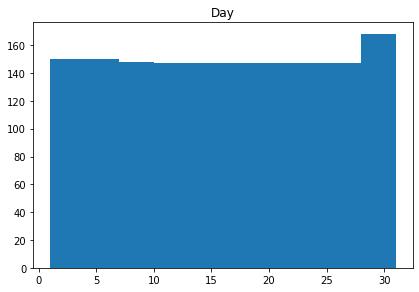

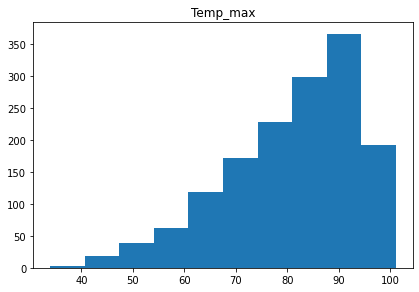

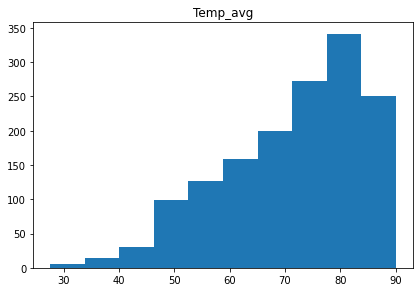

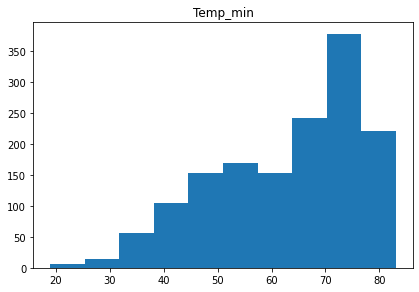

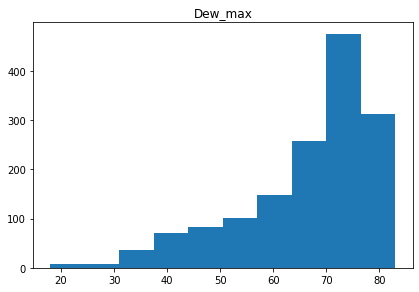

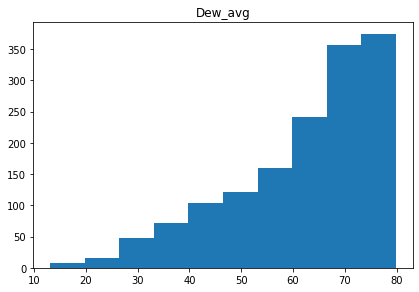

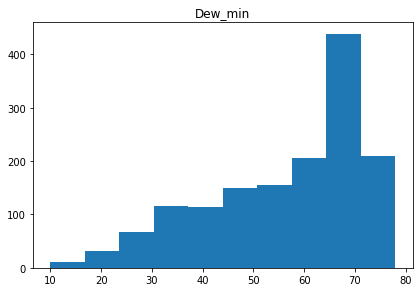

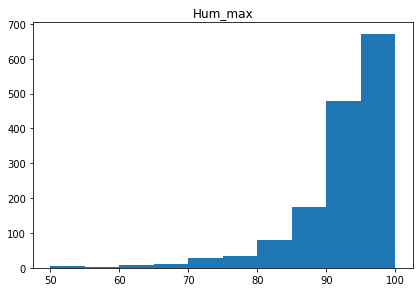

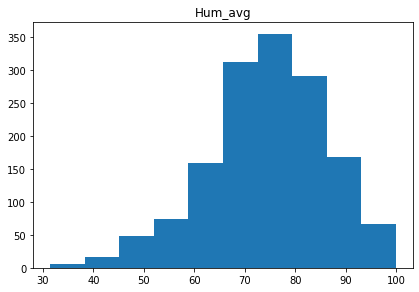

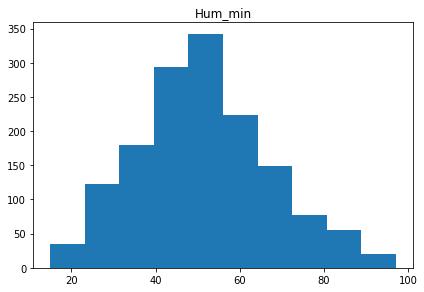

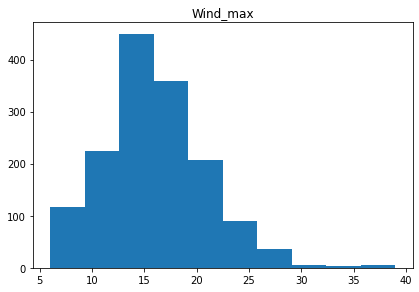

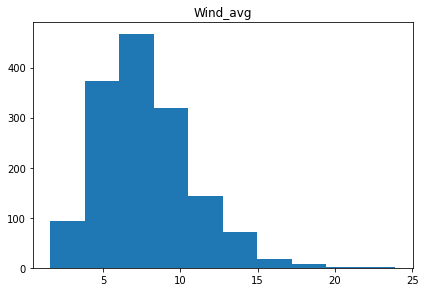

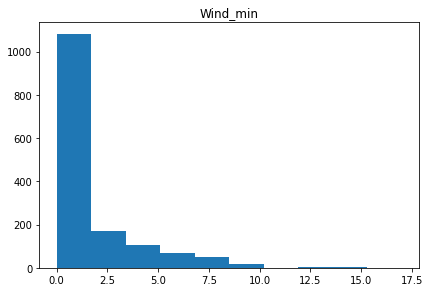

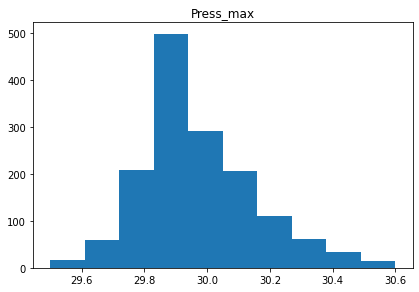

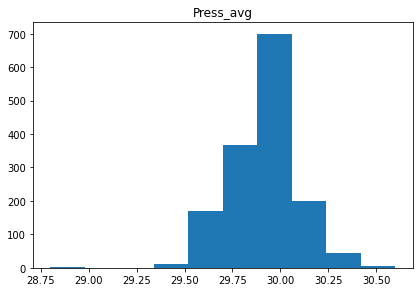

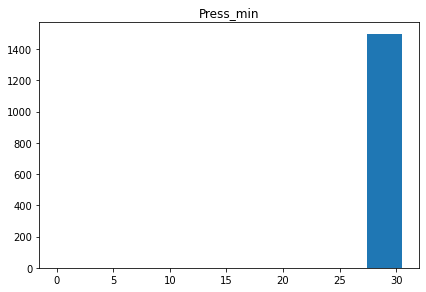

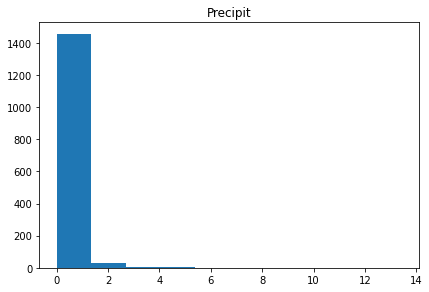

In [31]:
for feature in columns[1:-2]:
  fig, ax = plt.subplots()
  fig.tight_layout()
  ax.hist(x=df_cons_pred[feature])
  ax.set_title(feature)

In [30]:
df_cons_pred.describe()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week,consumption
count,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000
mean,15.670227,80.786382,71.277236,62.888518,66.261015,61.734579,56.506676,92.624166,74.487517,51.401869,15.899866,7.769025,1.391188,29.977303,29.906142,29.814753,0.160067,2.997330,21.399148
std,8.817041,12.652164,12.443023,13.493124,12.348885,13.685235,15.229231,7.748873,11.810572,15.718254,4.853153,3.007910,2.516049,0.167357,0.162033,0.787233,0.668120,1.999664,12.635139
min,1.000000,34.000000,27.600000,19.000000,18.000000,13.200000,10.000000,50.000000,31.500000,15.000000,6.000000,1.600000,0.000000,29.500000,28.800000,0.000000,0.000000,0.000000,4.610000
25%,8.000000,73.000000,62.900000,52.000000,60.250000,53.500000,45.000000,90.000000,67.500000,41.000000,13.000000,5.700000,0.000000,29.900000,29.800000,29.700000,0.000000,1.000000,10.828750
50%,16.000000,83.000000,73.800000,67.000000,70.000000,65.950000,62.000000,94.000000,75.200000,50.000000,15.000000,7.300000,0.000000,29.900000,29.900000,29.800000,0.000000,3.000000,16.833500
75%,23.000000,91.000000,81.600000,75.000000,76.000000,73.100000,70.000000,100.000000,82.800000,61.000000,18.000000,9.500000,3.000000,30.100000,30.000000,29.900000,0.020000,5.000000,30.726250
max,31.000000,101.000000,90.000000,83.000000,83.000000,79.800000,78.000000,100.000000,99.900000,97.000000,39.000000,23.900000,17.000000,30.600000,30.600000,30.500000,13.430000,6.000000,78.225300


In [36]:
maximos = [df_cons_pred[feature].max() for feature in columns[1:-1]]
maximos

[31,
 101,
 90.0,
 83,
 83,
 79.8,
 78,
 100,
 99.9,
 97,
 39,
 23.9,
 17,
 30.6,
 30.6,
 30.5,
 13.43,
 6]

In [37]:
minimos = [df_cons_pred[feature].min() for feature in columns[1:-1]]
minimos

[1,
 34,
 27.6,
 19,
 18,
 13.2,
 10,
 50,
 31.5,
 15,
 6,
 1.6,
 0,
 29.5,
 28.8,
 0.0,
 0.0,
 0]

###Analise correlação

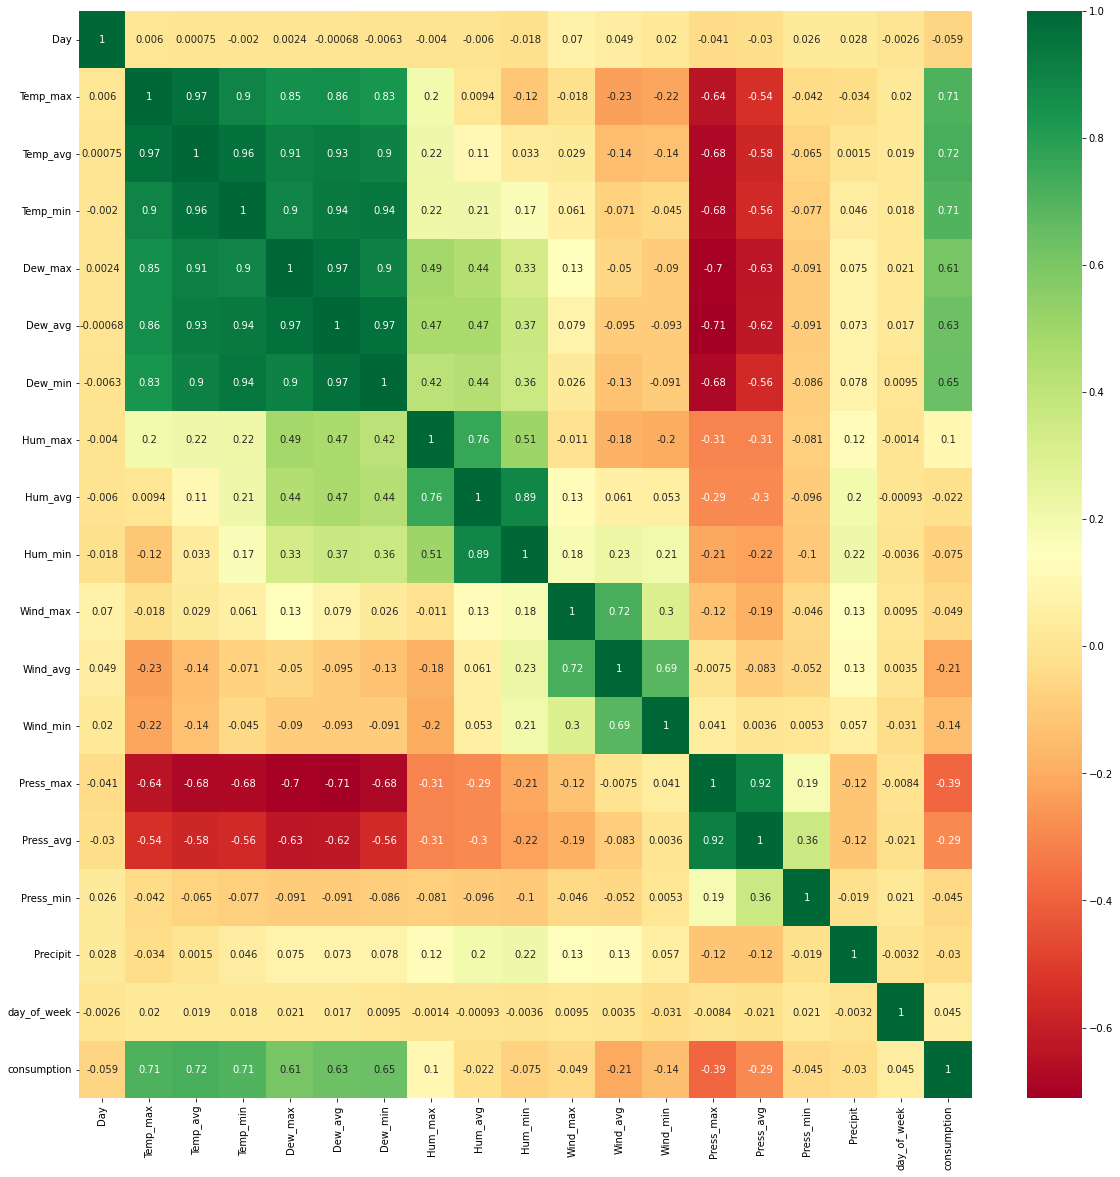

In [60]:
#get correlations of each features in dataset
corrmat = df_cons_pred.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cons_pred[top_corr_features].corr(),annot=True,cmap="RdYlGn")

##Feature engineering

##Testes

In [ ]:
df_cons_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 0 to 1497
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1498 non-null   datetime64[ns]
 1   Day          1498 non-null   int64         
 2   Temp_max     1498 non-null   int64         
 3   Temp_avg     1498 non-null   float64       
 4   Temp_min     1498 non-null   int64         
 5   Dew_max      1498 non-null   int64         
 6   Dew_avg      1498 non-null   float64       
 7   Dew_min      1498 non-null   int64         
 8   Hum_max      1498 non-null   int64         
 9   Hum_avg      1498 non-null   float64       
 10  Hum_min      1498 non-null   int64         
 11  Wind_max     1498 non-null   int64         
 12  Wind_avg     1498 non-null   float64       
 13  Wind_min     1498 non-null   int64         
 14  Press_max    1498 non-null   float64       
 15  Press_avg    1498 non-null   float64       
 16  Press_

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

In [ ]:
X = df_cons_pred.drop(columns=['consumption', 'Date'])
y = df_cons_pred.consumption

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
LM = LinearRegression()

In [ ]:
LM.fit(X_train, y_train)

LinearRegression()

In [ ]:
r2_score(y_test, LM.predict(X_test))

0.5902556596003716

In [ ]:
RFR = RandomForestRegressor()

In [ ]:
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
r2_score(y_test, RFR.predict(X_test))

0.740506551585453